<a href="https://colab.research.google.com/github/Eltensy/data-science-school-2025/blob/main/Data_Science_School_Lviv_Geo_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install osmnx geopandas matplotlib seaborn networkx shapely

import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
from osmnx import graph as ox_graph
from itertools import islice
from networkx import shortest_simple_paths
from itertools import permutations
import random

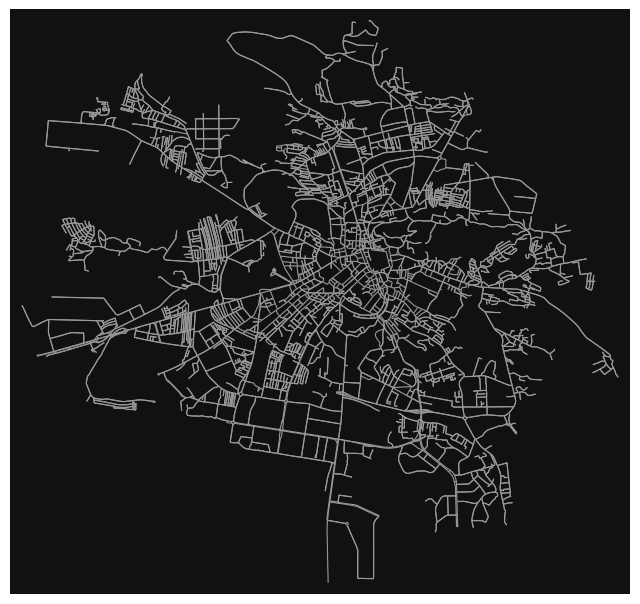

In [ ]:
graph = ox.graph_from_place("Lviv, Ukraine", network_type="drive") # Task 1a
fig, ax = ox.plot_graph(graph, node_size=0, edge_linewidth=0.8) # Task 1b

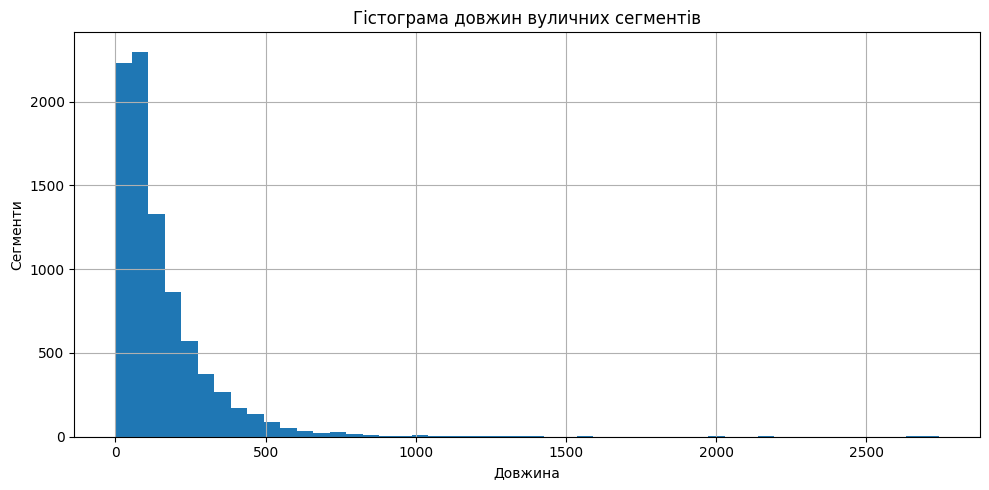

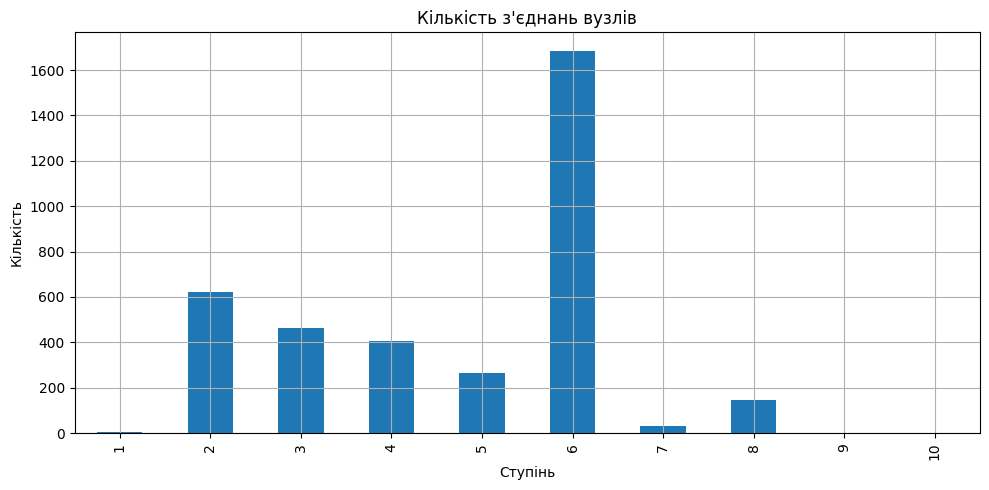

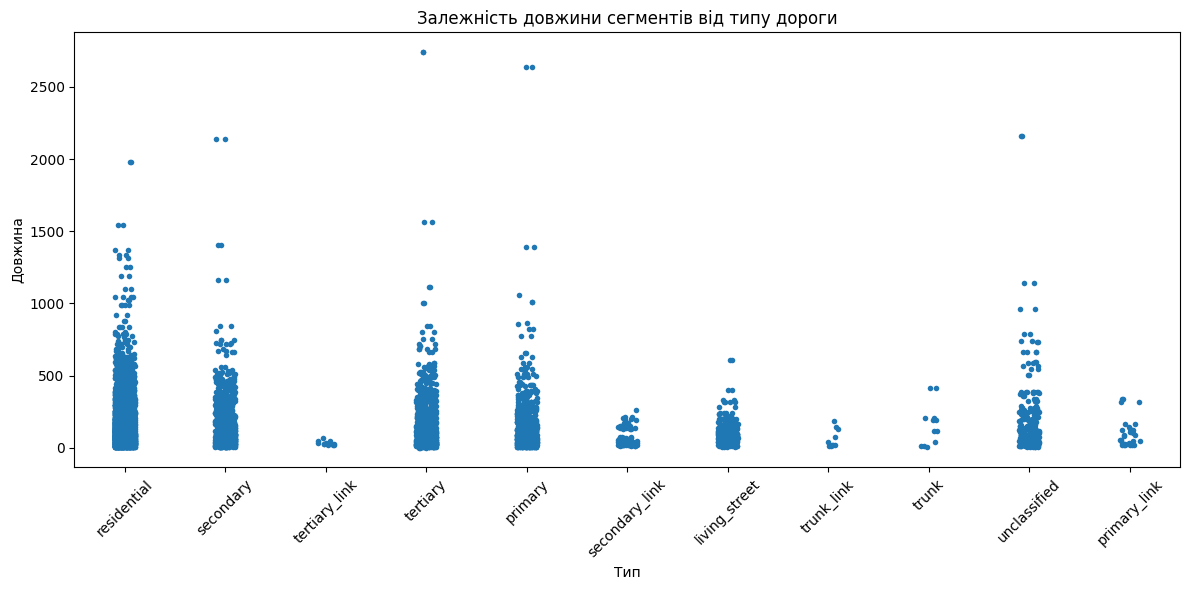

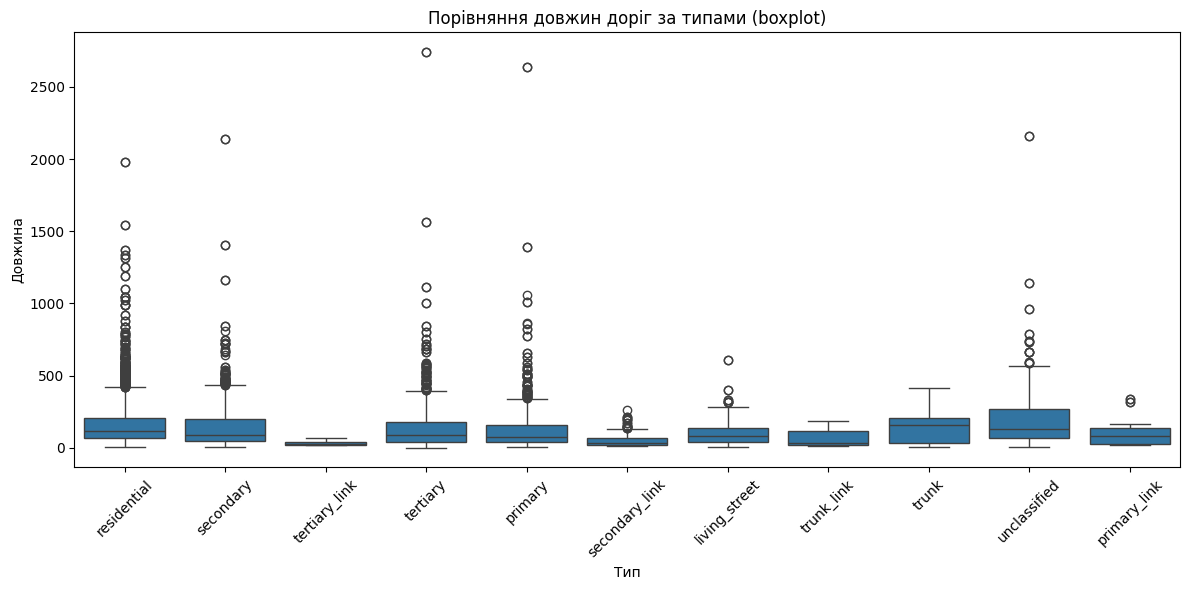

In [ ]:
# Task 1c
edges = ox.graph_to_gdfs(graph, nodes=False)

plt.figure(figsize=(10, 5))
edges['length'].hist(bins=50)
plt.title("Гістограма довжин вуличних сегментів")
plt.xlabel("Довжина")
plt.ylabel("Сегменти")
plt.grid(True)
plt.tight_layout()
plt.show()

node_degrees = dict(graph.degree())
degree_series = pd.Series(list(node_degrees.values()))

plt.figure(figsize=(10, 5))
degree_series.value_counts().sort_index().plot(kind='bar')
plt.title("Кількість з'єднань вузлів")
plt.xlabel("Ступінь")
plt.ylabel("Кількість")
plt.grid(True)
plt.tight_layout()
plt.show()

edges['highway_type'] = edges['highway'].apply(lambda x: x[0] if isinstance(x, list) else x)

plt.figure(figsize=(12, 6))
sns.stripplot(data=edges, x='highway_type', y='length', size=4, jitter=True)
plt.title("Залежність довжини сегментів від типу дороги")
plt.xlabel("Тип")
plt.ylabel("Довжина")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=edges, x='highway_type', y='length')
plt.title("Порівняння довжин доріг за типами (boxplot)")
plt.xlabel("Тип")
plt.ylabel("Довжина")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Дороги:
                          highway                   geometry
element id                                                  
node    30508651  traffic_signals  POINT (23.98275 49.82706)
        30508710  traffic_signals   POINT (24.0109 49.83974)
        30508730  traffic_signals  POINT (24.02285 49.84326)
        30508747  traffic_signals    POINT (24.0256 49.8444)
        30513635         crossing  POINT (24.00557 49.83554)

Будівлі:
                   building                   geometry
element id                                            
node    267079497       yes  POINT (24.03085 49.83853)
        2498133614   public   POINT (24.0281 49.83824)
        2866297721   bunker  POINT (24.02025 49.85695)
        3623229519   public  POINT (24.02133 49.85595)
        3738970632   school   POINT (24.05652 49.7832)


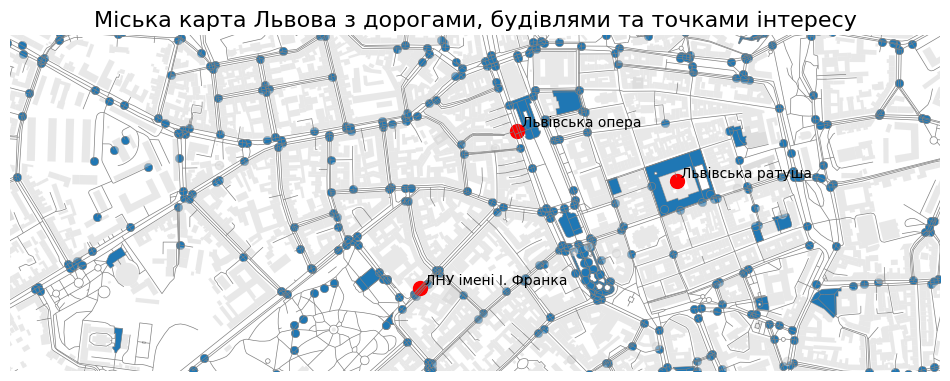

In [ ]:
# Task 2a
road_tags = {"highway": True}
roads = ox.features_from_place("Lviv, Ukraine", road_tags)

building_tags = {"building": True}
buildings = ox.features_from_place("Lviv, Ukraine", building_tags)

print("Дороги:")
print(roads[['highway', 'geometry']].head())

print("\nБудівлі:")
print(buildings[['building', 'geometry']].head())

# Task 2b
points_data = {
    'name': ['Львівська опера', 'ЛНУ імені І. Франка', 'Львівська ратуша'],
    'type': ['театр', 'університет', 'музей'],
    'geometry': [
        Point(24.026366, 49.843002),
        Point(24.02324, 49.83972),
        Point(24.031515, 49.841952)
    ]
}

points = gpd.GeoDataFrame(points_data, crs='EPSG:4326') # розміщуємо поінти відповідно до координатної системи

# Task 2c + 2d
fig, ax = plt.subplots(figsize=(12, 12))

roads.plot(ax=ax, linewidth=0.5, edgecolor='gray', label='Дороги')

buildings.plot(ax=ax, color='lightgray', alpha=0.5, label='Будівлі')

points.plot(ax=ax, color='red', markersize=100, label='Точкові об\'єкти')

for idx, row in points.iterrows():
    ax.annotate(row['name'], xy=(row['geometry'].x, row['geometry'].y), xytext=(3, 3), textcoords="offset points")

# приближення масштабу карти, щоб було краще видно потрібні точки
ax.set_xlim([24.01, 24.04])
ax.set_ylim([49.838, 49.845])


ax.set_title("Міська карта Львова з дорогами, будівлями та точками інтересу", fontsize=16)
ax.axis('off')
plt.show()

In [ ]:
G = ox.graph_from_place("Lviv, Ukraine", network_type='walk')
station_point = (49.841100, 24.018900) # цирк
opera_point = (49.841952, 24.031515) # Ратуша

orig_node = ox.distance.nearest_nodes(G, station_point[1], station_point[0])
dest_node = ox.distance.nearest_nodes(G, opera_point[1], opera_point[0])


Маршрут 1: Довжина = 1172 м
Маршрут 2: Довжина = 1225 м
Маршрут 3: Довжина = 1387 м


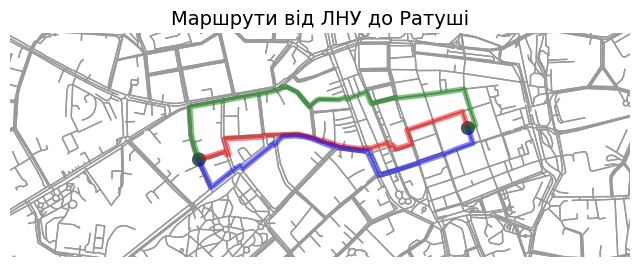

In [ ]:
# Task 3 a b c d
def route_length(G, route):
    total = 0
    for u, v in zip(route[:-1], route[1:]):
        data = G.get_edge_data(u, v)
        if isinstance(data, dict):
            if "length" in data:
                total += data["length"]
            elif 0 in data and "length" in data[0]:  # multigraph
                total += data[0]["length"]
    return int(total)

def penalize_route_edges(G, route, penalty=1000):
    for u, v in zip(route[:-1], route[1:]):
        if G.has_edge(u, v):
            G[u][v]['length'] += penalty

# трансформ в простий DiGraph
G_simple = nx.DiGraph()
for u, v, data in G.edges(data=True):
    length = data.get("length", 1)
    if G_simple.has_edge(u, v):
        if length < G_simple[u][v]["length"]:
            G_simple[u][v]["length"] = length
    else:
        G_simple.add_edge(u, v, length=length)

G_modifiable = G_simple.copy()

# генерація 3 маршрутів з фунцією penalize щоб запобігати однакових/дуже подібних маршрутів
k_routes = []
for _ in range(3):
    try:
        route = nx.shortest_path(G_modifiable, orig_node, dest_node, weight="length")
        k_routes.append(route)
        penalize_route_edges(G_modifiable, route, penalty=500)
    except nx.NetworkXNoPath:
        break

# довжини
lengths = {}
for i, route in enumerate(k_routes):
    dist = route_length(G_simple, route)
    lengths[f"Маршрут {i+1}"] = dist
    print(f"Маршрут {i+1}: Довжина = {dist} м")

# візуалізація
colors = ['red', 'blue', 'green']
routes_to_plot = k_routes[:3]

fig, ax = ox.plot_graph_routes(
    G,
    routes=routes_to_plot,
    route_colors=colors[:len(routes_to_plot)],
    route_linewidth=4,
    node_size=0,
    bgcolor='white',
    show=False,
    close=False
)

# Зум
ax.set_xlim([24.01, 24.04])
ax.set_ylim([49.838, 49.845])

plt.title("Маршрути від ЛНУ до Ратуші", fontsize=14)
plt.show()

In [ ]:
# Task 4 a b
places = {
    "Залізничний вокзал": (49.839683, 24.012446),
    "Оперний театр": (49.844014, 24.026502),
    "Площа Ринок": (49.841952, 24.031592),
    "Домініканський собор": (49.841445, 24.035374),
    "Каплиця Боїмів": (49.841328, 24.030614),
    "Високий Замок": (49.848391, 24.037288),
    "Палац Потоцьких": (49.837014, 24.025880),
    "Львівська Політехніка": (49.835361, 24.013208),
    "Арсенал": (49.843072, 24.030277),
    "Собор Святого Юра": (49.839013, 24.012750),
    "Костел Єзуїтів": (49.842760, 24.030957),
}

places_xy = {name: ox.distance.nearest_nodes(G, lng, lat) for name, (lat, lng) in places.items()}

nodes = list(places_xy.values())
dist_matrix = {
    (i, j): nx.shortest_path_length(G, i, j, weight='length')
    for i in nodes for j in nodes if i != j
}
# оптимальний маршрут перебором
start = places_xy["Залізничний вокзал"]
other_nodes = [n for n in nodes if n != start]

best_order = None
min_total = float("inf")

for perm in permutations(other_nodes):
    route = [start] + list(perm) + [start]
    total = sum(dist_matrix[(route[i], route[i+1])] for i in range(len(route) - 1))
    if total < min_total:
        min_total = total
        best_order = route

print(f"Оптимальна довжина маршруту: {min_total} м")

# рандомний маршрут
rand_order = [start] + random.sample(other_nodes, len(other_nodes)) + [start]
rand_total = sum(dist_matrix[(rand_order[i], rand_order[i+1])] for i in range(len(rand_order) - 1))
print(f"Довжина випадкового маршруту: {rand_total} м")

# повний шлях за маршрутом
full_route = []
for u, v in zip(best_order[:-1], best_order[1:]):
    path = nx.shortest_path(G, u, v, weight='length')
    full_route.extend(path[:-1])
full_route.append(best_order[-1])

Оптимальна довжина маршруту: 7046.682586611178 м
Довжина випадкового маршруту: 12406.200887601351 м


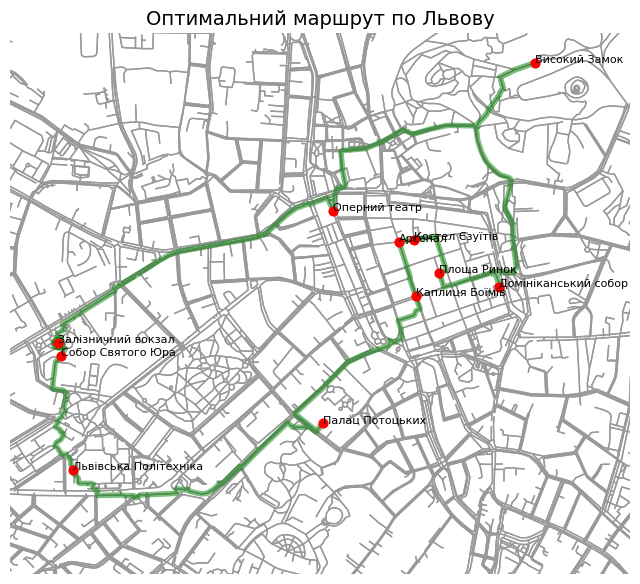

In [ ]:
# Task 4 c d
# оптимальний маршрут
fig, ax = ox.plot_graph_route(
    G,
    full_route,
    route_color='green',
    route_linewidth=4,
    node_size=0,
    bgcolor='white',
    show=False,
    close=False
)
# зум на центр львова
ax.set_xlim([24.010, 24.042])
ax.set_ylim([49.832, 49.850])

# точки на карті
for name, node in places_xy.items():
    x, y = G.nodes[node]['x'], G.nodes[node]['y']
    ax.scatter(x, y, c='red', s=40, zorder=5)
    ax.text(x, y, name, fontsize=8, color='black', zorder=10)

plt.title("Оптимальний маршрут по Львову", fontsize=14)
plt.show()

In [ ]:
# Task 5 Bonus
import plotly.graph_objects as go

places = {
    "Залізничний вокзал": (49.839683, 24.012446),
    "Оперний театр": (49.844014, 24.026502),
    "Площа Ринок": (49.841952, 24.031592),
    "Високий Замок": (49.848391, 24.037288),
    "Собор Святого Юра": (49.839013, 24.012750),
}

lats = [lat for lat, lon in places.values()]
lons = [lon for lat, lon in places.values()]
names = list(places.keys())

# генерація маршруту
route_lats = lats + [lats[0]]  # замкнене коло
route_lons = lons + [lons[0]]

fig = go.Figure()

# маршрут
fig.add_trace(go.Scattermapbox(
    lat=route_lats,
    lon=route_lons,
    mode='lines+markers',
    line=dict(width=3, color='blue'),
    marker=dict(size=8, color='red'),
    text=names + [names[0]],
    hoverinfo='text'
))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=14,
    mapbox_center={"lat": 49.842, "lon": 24.03},
    margin={"r":0,"t":30,"l":0,"b":0},
    title="Інтерактивна карта"
)

# HTML файл
fig.write_html("plotly_map_lviv.html")
fig.show()